# Predicting Customer Churn - Experiment: Visualizing a fitting curve 

## Setup

### Coding constants

In [1]:
GRAPH_WIDTH = 10
GRAPH_HEIGHT = 5

### Common imports

In [3]:
# Data processing 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Data visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Data loading

In [4]:
df = pd.read_csv('data/customer-churn.csv')
df.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,LEAVE
0,0,31953,0,6,313378,161,0,4,3,3,1,1
1,1,36147,0,13,800586,244,0,6,3,3,2,1
2,1,27273,230,0,305049,201,16,15,3,4,3,1
3,0,120070,38,33,788235,780,3,2,3,0,2,0
4,1,29215,208,85,224784,241,21,1,4,3,0,1


In [5]:
df.shape

(20000, 12)

In [6]:
df.columns

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL',
       'CONSIDERING_CHANGE_OF_PLAN', 'LEAVE'],
      dtype='object')

## Experiment: Visualizing a fitting curve

We will keep using our simple measure of performance that computes the ratio between correct and wrong predictions:

In [7]:
def evaluate_performance(model, training, labels):
    labels_pred = model.predict(training)
    n_correct = sum(labels_pred == labels)   
    performance = n_correct / len(labels_pred)
  
    return performance

Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is train_test_split(). This function has a random_state parameter that allows you to set the random generator seed, useful for obtaining the same split every time we call train_test_split with the same random state.

We will split our data into two sets:
- One set called training set
- One set called holdout set

In [8]:
training_set, holdout_set = train_test_split(df, test_size=0.2, random_state=15)

print(training_set.shape)
print(holdout_set.shape)

(16000, 12)
(4000, 12)


Split the training set into two dataframes:
- One dataframe containing all the attributes
- One dataframe containing all the labels, i.e., the values of the target variable (LEAVE)

In [9]:
training_attr = training_set.loc[:, training_set.columns != 'LEAVE']
training_labels = training_set['LEAVE']

Perform the same task for the holdout set

In [10]:
holdout_attr = holdout_set.loc[:, holdout_set.columns != 'LEAVE']
holdout_labels = holdout_set['LEAVE']

We will build many decision trees with a different depth each. For each decision tree built, we will have three considerations:
1. First, we will build the decision tree using the training set
2. Second, we will assess the accuracy (performance or error) of the decision tree on the training set
3. Third, we will also assess the accuracy of the decision tree on the holdout set.

The purpose of this experiment is to measure the accuracy of a decision tree on training and holdout sets as we vary the depth of the tree. 

**Note the holdout set was not used to train the model; thus, measuring accuracy on the holdout set gives us an estimation of generalization performance.**  

In [11]:
training_performance_values = []
holdout_performance_values = []
depth_values = []

for depth in range(1, 51, 1):    
    tree_clf = DecisionTreeClassifier(max_depth = depth)
    tree_clf.fit(training_attr, training_labels)
    
    training_performance = evaluate_performance(tree_clf, training_attr, training_labels)
    training_performance_values.append(training_performance)
    
    holdout_performance = evaluate_performance(tree_clf, holdout_attr, holdout_labels)
    holdout_performance_values.append(holdout_performance)

    depth_values.append(depth)

Create a dataframe with the results of the experiment to facilitate building the graph:

In [12]:
fitting_curve = pd.DataFrame({
    'Performance on training data': training_performance_values,
    'Performance on holdout data': holdout_performance_values,
}, index= depth_values)

fitting_curve.head()

,Performance on training data,Performance on holdout data
1,0.621812,0.61200
2,0.646437,0.64325
3,0.662500,0.66425
4,0.688625,0.68825
5,0.695812,0.69100


Text(0, 0.5, 'Accuracy')

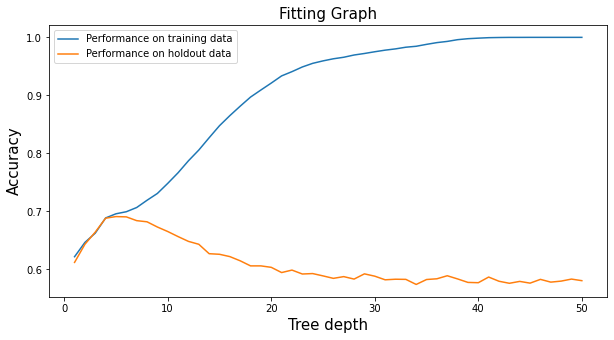

In [13]:
plt.figure(figsize=(GRAPH_WIDTH, GRAPH_HEIGHT))

plot = sns.lineplot(
    data=fitting_curve,
    dashes=False)

plot.set_title('Fitting Graph', fontsize = 15)
plot.set_xlabel("Tree depth", fontsize = 15)
plot.set_ylabel("Accuracy", fontsize = 15)

The fitting curve shows a typical inverted U-shape for the accuracy of the models on the holdout set.

Beginning at the left, the tree is very small and has poor performance. As it is allowed more and more nodes it improves rapidly, and both training-set accuracy and holdoutset accuracy improve. Also we see that training-set accuracy always is at least a little better than holdout-set accuracy, since we did get to look at the training data when building the model.

> At some point the tree starts to overfit: it acquires details of the training set that are not characteristic of the population in general, as represented by the holdout set.

In this experiment overfitting starts to happen at around depth = 5, known as a "sweet spot". As the trees are allowed to get larger, the training set accuracy continues to increase—in fact, it is capable of memorizing the entire training set if we let it, leading to an accuracy of 1.0.

But the holdout accuracy declines as the tree grows past its “sweet spot”; the data subsets at the leaves get smaller
and smaller, and the model generalizes from fewer and fewer data. Such inferences will be increasingly error-prone and the performance on the holdout data suffers.